In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import duckdb
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize':(8,5)})

# ML imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, roc_curve, average_precision_score)
import joblib

# File paths
CLEANED_CSV = "./bank_dataset_cleaned.csv"  # optional backup
EXPORT_FOR_PBI = "./data/powerbi_dataset.xlsx"
MODEL_PATH = "./models/dormancy_model.pkl"

In [4]:
con = duckdb.connect(':memory:')
client = MongoClient("mongodb://localhost:27017/")
db = client["dormancy_db"]

customers = pd.DataFrame(list(db.customers.find()))
accounts  = pd.DataFrame(list(db.accounts.find()))
txns      = pd.DataFrame(list(db.transactions.find()))

for df in (customers, accounts, txns):
    if '_id' in df.columns:
        df.drop(columns=['_id'], inplace=True)

print("Loaded:")
print("Customers:", customers.shape)
print("Accounts :", accounts.shape)
print("Txns     :", txns.shape)


Loaded:
Customers: (5000, 7)
Accounts : (5000, 6)
Txns     : (5000, 40)


In [5]:
con.register('txns', txns)
sql = """
WITH ref AS (
    SELECT MAX(STRPTIME(transaction_date, '%d-%m-%Y')) AS ref_date
    FROM txns
),
last_txn AS (
    SELECT
        customer_id,
        MAX(STRPTIME(transaction_date, '%d-%m-%Y')) AS last_txn_date,
        COUNT(*) AS txn_count
    FROM txns
    GROUP BY customer_id
)
SELECT
    t.customer_id,
    t.first_name,
    t.last_name,
    t.age,
    t.gender,
    t.city,
    t.account_type,
    t.account_balance,
    t.date_of_account_opening,
    last_txn.last_txn_date,
    last_txn.txn_count,
    ref.ref_date,
    DATEDIFF(
        'day',
        last_txn.last_txn_date,
        ref.ref_date
    ) AS days_since_last_txn
FROM txns t
JOIN last_txn
    ON t.customer_id = last_txn.customer_id
CROSS JOIN ref
"""
master_df = con.execute(sql).df()
master_df.head()


,customer_id,first_name,last_name,age,gender,city,account_type,account_balance,date_of_account_opening,last_txn_date,txn_count,ref_date,days_since_last_txn
0,1,Joshua,Hall,45,M,Fort Worth,Current,1313.38,26-05-2006,2023-12-07,1,2023-12-31,24
1,2,Mark,Taylor,47,F,Louisville,Current,5988.46,02-03-2006,2023-04-27,1,2023-12-31,248
2,3,Joseph,Flores,25,F,Philadelphia,Current,8277.88,19-07-2015,2023-04-05,1,2023-12-31,270
3,4,Kevin,Lee,52,OTHER,Oklahoma City,Savings,7487.21,30-01-2008,2023-07-28,1,2023-12-31,156
4,5,Linda,Johnson,68,OTHER,Phoenix,Savings,6993.55,25-05-2021,2023-01-16,1,2023-12-31,349


In [6]:
master_df['ref_date'] = pd.to_datetime(master_df['ref_date'], errors='coerce')
master_df['date_of_account_opening'] = pd.to_datetime(
    master_df['date_of_account_opening'], errors='coerce'
)


In [8]:
# Cell: clean & feature basics
# If accounts with no transactions -> last_txn_date NaT; treat days_since_last_txn as large number or mark separately
master_df['last_txn_date'] = pd.to_datetime(master_df['last_txn_date'])
master_df['days_since_last_txn'] = master_df['days_since_last_txn'].fillna((master_df['ref_date'] - master_df['date_of_account_opening']).dt.days.fillna(9999))
# If age missing, fill with median
if 'age' in master_df.columns:
    master_df['age'] = master_df['age'].fillna(master_df['age'].median())

# dormancy rule
DORMANCY_THRESHOLD = 90
master_df['is_dormant'] = (master_df['days_since_last_txn'] > DORMANCY_THRESHOLD).astype(int)

# extra features
master_df['account_age_days'] = (master_df['ref_date'] - pd.to_datetime(master_df['date_of_account_opening'])).dt.days.fillna(0).astype(int)
master_df['age_group'] = pd.cut(master_df['age'].fillna(0),
                                bins=[0,25,35,45,60,120],
                                labels=['<25','26-35','36-45','46-60','60+'])
# save a backup
master_df.to_csv(CLEANED_CSV, index=False)
master_df.shape

(5000, 16)

In [9]:
master_df.rename(
    columns={'days_since_last_transaction': 'days_since_last_txn'},
    inplace=True
)
# Convert all date columns to datetime FIRST
date_cols = [
    'last_txn_date',
    'ref_date',
    'date_of_account_opening'
]

for col in date_cols:
    master_df[col] = pd.to_datetime(master_df[col], errors='coerce')


In [10]:
# Handle missing inactivity days
master_df['days_since_last_txn'] = master_df['days_since_last_txn'].fillna(
    (master_df['ref_date'] - master_df['date_of_account_opening'])
    .dt.days
    .fillna(9999)
)

# Age
if 'age' in master_df.columns:
    master_df['age'] = master_df['age'].fillna(master_df['age'].median())

# Dormancy flag
DORMANCY_THRESHOLD = 90
master_df['is_dormant'] = (master_df['days_since_last_txn'] > DORMANCY_THRESHOLD).astype(int)

# Account age
master_df['account_age_days'] = (
    master_df['ref_date'] - master_df['date_of_account_opening']
).dt.days.fillna(0).astype(int)

# Age groups
master_df['age_group'] = pd.cut(
    master_df['age'].fillna(0),
    bins=[0, 25, 35, 45, 60, 120],
    labels=['<25', '26-35', '36-45', '46-60', '60+']
)


In [11]:
# Ensure transaction_date is datetime
txns['transaction_date'] = pd.to_datetime(
    txns['transaction_date'],
    format='%d-%m-%Y',   # because your data is DD-MM-YYYY
    errors='coerce'
)


In [12]:
# NEW CELL4.1 — future dormancy target

# OBS_DATE = master_df['ref_date'].max() - pd.Timedelta(days=30)
OBS_DATE = master_df['ref_date'].max() - pd.Timedelta(days=30)

# transactions before observation date
txns_before = txns[txns['transaction_date'] <= OBS_DATE]

# last_txn_obs = (
#     txns_before
#     .groupby('account_id')['txn_date']
#     .max()
#     .reset_index()
#     .rename(columns={'txn_date':'last_txn_before_obs'})
# )
last_txn_obs = (
    txns_before
    .groupby('customer_id')['transaction_date']
    .max()
    .reset_index()
    .rename(columns={'transaction_date': 'last_txn_before_obs'})
)

# features = accounts.merge(last_txn_obs, on='account_id', how='left')
features = master_df.merge(
    last_txn_obs,
    on='customer_id',
    how='left'
)

# features['days_since_last_txn_obs'] = (
#     OBS_DATE - features['last_txn_before_obs']
# ).dt.days.fillna(999)
features['days_since_last_txn_obs'] = (
    OBS_DATE - features['last_txn_before_obs']
).dt.days.fillna(999)

# FUTURE WINDOW
FUTURE_WINDOW = 30

txns_future = txns[
    (txns['transaction_date'] > OBS_DATE) &
    (txns['transaction_date'] <= OBS_DATE + pd.Timedelta(days=FUTURE_WINDOW))
]
# active_future_customers = set(txns_future['customer_id'])

# features['will_be_dormant_30d'] = (
#     ~features['customer_id'].isin(active_future_customers)
# ).astype(int)

active_future_accounts = set(txns_future['customer_id'])

features['will_be_dormant_30d'] = ~features['customer_id'].isin(active_future_accounts)
features['will_be_dormant_30d'] = features['will_be_dormant_30d'].astype(int)

In [13]:
features.head()

,customer_id,first_name,last_name,age,gender,city,account_type,account_balance,date_of_account_opening,last_txn_date,txn_count,ref_date,days_since_last_txn,is_dormant,account_age_days,age_group,last_txn_before_obs,days_since_last_txn_obs,will_be_dormant_30d
0,1,Joshua,Hall,45,M,Fort Worth,Current,1313.38,2006-05-26,2023-12-07,1,2023-12-31,24,0,6428,36-45,NaT,999.0,0
1,2,Mark,Taylor,47,F,Louisville,Current,5988.46,2006-03-02,2023-04-27,1,2023-12-31,248,1,6513,46-60,2023-04-27,218.0,1
2,3,Joseph,Flores,25,F,Philadelphia,Current,8277.88,2015-07-19,2023-04-05,1,2023-12-31,270,1,3087,<25,2023-04-05,240.0,1
3,4,Kevin,Lee,52,OTHER,Oklahoma City,Savings,7487.21,2008-01-30,2023-07-28,1,2023-12-31,156,1,5814,46-60,2023-07-28,126.0,1
4,5,Linda,Johnson,68,OTHER,Phoenix,Savings,6993.55,2021-05-25,2023-01-16,1,2023-12-31,349,1,950,60+,2023-01-16,319.0,1


In [14]:
# ===============================
# Cell 5: Time-aware gap features
# ===============================

# Ensure datetime
txns['transaction_date'] = pd.to_datetime(txns['transaction_date'])
features['last_txn_before_obs'] = pd.to_datetime(features['last_txn_before_obs'])

# Sort transactions
txns_sorted = txns.sort_values(['customer_id', 'transaction_date'])

# Compute transaction gaps
txns_sorted['txn_gap_days'] = (
    txns_sorted
    .groupby('customer_id')['transaction_date']
    .diff()
    .dt.days
)

# Aggregate gap features
gap_features = (
    txns_sorted
    .groupby('customer_id')['txn_gap_days']
    .agg([
        ('last_txn_gap_days', 'last'),
        ('mean_txn_gap_days', 'mean'),
        ('std_txn_gap_days', 'std')
    ])
    .reset_index()
)

# Merge gap features
features = features.merge(
    gap_features,
    on='customer_id',
    how='left'
)

# Recent transaction gap (difference between last two txns before OBS_DATE)
recent_gap = (
    txns_sorted
    .dropna(subset=['txn_gap_days'])
    .groupby('customer_id')
    .tail(1)[['customer_id', 'txn_gap_days']]
    .rename(columns={'txn_gap_days': 'recent_txn_gap_days'})
)

features = features.merge(
    recent_gap,
    on='customer_id',
    how='left'
)

# -------------------------------
# Cap recency to avoid dominance
# -------------------------------
features['days_since_last_txn_obs_capped'] = (
    features['days_since_last_txn_obs']
    .clip(upper=180)
)

print("✅ Time-aware features added")
print(features[[
    'days_since_last_txn_obs_capped',
    'last_txn_gap_days',
    'mean_txn_gap_days',
    'std_txn_gap_days',
    'recent_txn_gap_days'
]].head())


✅ Time-aware features added
   days_since_last_txn_obs_capped  last_txn_gap_days  mean_txn_gap_days  \
0                           180.0                NaN                NaN   
1                           180.0                NaN                NaN   
2                           180.0                NaN                NaN   
3                           126.0                NaN                NaN   
4                           180.0                NaN                NaN   

   std_txn_gap_days  recent_txn_gap_days  
0               NaN                  NaN  
1               NaN                  NaN  
2               NaN                  NaN  
3               NaN                  NaN  
4               NaN                  NaN  


In [15]:
# ===============================
# Cell 6: Features & Preprocessing
# ===============================

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# -------------------------------
# Target
# -------------------------------
target = 'will_be_dormant_30d'

# -------------------------------
# Candidate features (FINAL)
# -------------------------------
candidate_features = [
    # Core demographics / account info
    'age',
    'account_balance',
    'account_age_days',

    # Activity volume
    'txn_count',

    # Recency (leakage-safe)
    'days_since_last_txn_obs_capped',

    # 🔥 Time-aware behavioral features
    'last_txn_gap_days',
    'mean_txn_gap_days',
    'std_txn_gap_days',
    'recent_txn_gap_days',

    # Categorical
    'account_type',
    'city',
    'gender'
]

# -------------------------------
# Build X and y (IMPORTANT)
# -------------------------------
X = features[candidate_features].copy()
y = features[target].copy()

# -------------------------------
# Train / Test split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Target distribution:")
print(y_train.value_counts(normalize=True))

# -------------------------------
# Numeric / Categorical split
# -------------------------------
numeric_features = [
    'age',
    'account_balance',
    'account_age_days',
    'txn_count',
    'days_since_last_txn_obs_capped',
    'last_txn_gap_days',
    'mean_txn_gap_days',
    'std_txn_gap_days',
    'recent_txn_gap_days'
]

categorical_features = [
    'account_type',
    'city',
    'gender'
]

# -------------------------------
# Transformers
# -------------------------------
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# -------------------------------
# Column Transformer
# -------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

# -------------------------------
# Sanity check (DO NOT SKIP)
# -------------------------------
missing = set(candidate_features) - set(X.columns)
print("Missing columns:", missing)
assert len(missing) == 0, "❌ Feature mismatch — fix before training"


Target distribution:
will_be_dormant_30d
1    0.91725
0    0.08275
Name: proportion, dtype: float64
Missing columns: set()


In [16]:
# ===============================
# Cell B: Logistic Regression
# ===============================

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score
)

# -------------------------------
# Pipeline
# -------------------------------
pipe_lr = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        solver='lbfgs'
    ))
])

# -------------------------------
# Hyperparameter grid
# -------------------------------
param_grid = {
    'clf__C': [0.01, 0.05, 0.1, 0.5, 1.0],
    'clf__penalty': ['l2']
}

# -------------------------------
# Cross-validation
# -------------------------------
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# -------------------------------
# GridSearch (PR-AUC focused)
# -------------------------------
lr_grid = GridSearchCV(
    estimator=pipe_lr,
    param_grid=param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# -------------------------------
# Fit
# -------------------------------
lr_grid.fit(X_train, y_train)

print("Best parameters:", lr_grid.best_params_)
print("Best CV PR-AUC:", lr_grid.best_score_)

# -------------------------------
# Test set evaluation
# -------------------------------
best_lr = lr_grid.best_estimator_

y_pred = best_lr.predict(X_test)
y_pred_proba = best_lr.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))
print("PR AUC:", average_precision_score(y_test, y_pred_proba))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'clf__C': 1.0, 'clf__penalty': 'l2'}
Best CV PR-AUC: 0.9743182334795379

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.96      0.27        83
           1       0.99      0.53      0.69       917

    accuracy                           0.57      1000
   macro avg       0.58      0.75      0.48      1000
weighted avg       0.92      0.57      0.66      1000

ROC AUC: 0.7469091195753571
PR AUC: 0.9738261482487973


In [18]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

pr_df = pd.DataFrame({
    'threshold': thresholds,
    'precision': precision[:-1],
    'recall': recall[:-1]
})

pr_df.sort_values('threshold').head()


,threshold,precision,recall
0,0.136825,0.917000,1.000000
1,0.155932,0.916917,0.998909
2,0.161895,0.916834,0.997819
3,0.163213,0.916750,0.996728
4,0.165129,0.916667,0.995638


In [19]:
def evaluate_model(
    model_pipeline,
    X_test,
    y_test,
    name="Model",
    threshold=0.16,          # ← IMPORTANT
    precision_target=0.9
):
    proba = model_pipeline.predict_proba(X_test)[:,1]
    pred = (proba >= threshold).astype(int)

    print(f"\n--- {name} ---")
    print(f"Decision threshold: {threshold}")
    print(classification_report(y_test, pred))
    print("ROC AUC:", roc_auc_score(y_test, proba))
    print("PR AUC:", average_precision_score(y_test, proba))

    # Precision–Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, proba)

    pr_df = pd.DataFrame({
        'threshold': thresholds,
        'precision': precision[:-1],
        'recall': recall[:-1]
    })

    best_row = pr_df[pr_df['precision'] >= precision_target] \
        .sort_values('recall', ascending=False).head(1)

    print("\nBest threshold for precision ≥", precision_target)
    print(best_row)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, proba):.3f})")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC Curve - {name}')
    plt.legend(); plt.show()

    # PR Curve
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f"{name} (AP={average_precision_score(y_test, proba):.3f})")
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(f'Precision-Recall - {name}')
    plt.legend(); plt.show()



--- Logistic Regression (Final) ---
Decision threshold: 0.16
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        83
           1       0.92      1.00      0.96       917

    accuracy                           0.92      1000
   macro avg       0.46      0.50      0.48      1000
weighted avg       0.84      0.92      0.88      1000

ROC AUC: 0.7469091195753571
PR AUC: 0.9738261482487973

Best threshold for precision ≥ 0.9
   threshold  precision  recall
0   0.136825      0.917     1.0


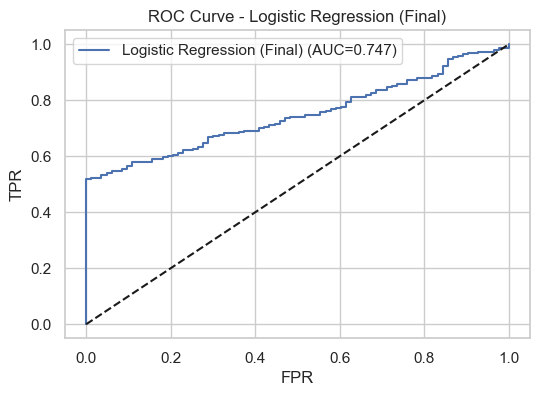

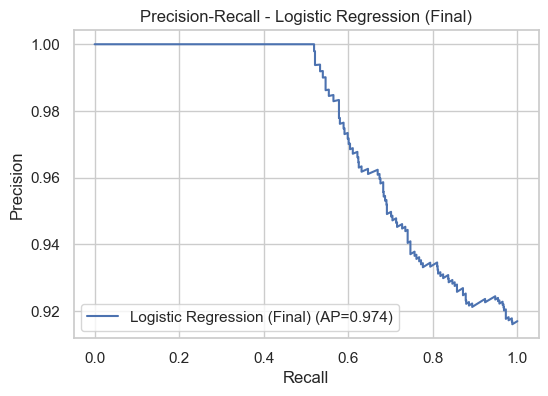

In [20]:
# ===============================
# FINAL Evaluation Cell
# ===============================

evaluate_model(
    model_pipeline=lr_grid.best_estimator_,
    X_test=X_test,
    y_test=y_test,
    name="Logistic Regression (Final)",
    threshold=0.16,
    precision_target=0.90
)
